Reference:
https://msurtsukov.github.io/Neural-ODE/ 

In [6]:
import math 
import numpy as np 
import os
import pandas as pd 
import torch 
from torch.autograd import grad, Variable 
import torch.nn as nn 
from torch.nn import functional as F 
import torchvision 
from tqdm import tqdm_notebook as tqdm  
from IPython.display import clear_output 

In [5]:
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
%matplotlib inline 

In [2]:
torch.__version__

'1.13.1'

In [7]:
use_cuda = torch.cuda.is_available()
use_cuda 

False

In [8]:
def ode_solve(z0, t0, t1, f):
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())
    
    h = (t1 - t0) / n_steps
    t = t0
    z = z0
    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h 
    return z 


In [232]:
class ODEF(nn.Module):
    
    def forward_with_grad(self, z, t, grad_outputs):
        """ compute a df/dz, a df/dt, a df/dp, and f """
        batch_size = z.shape[0]
        
        out = self.forward(z, t)
        
        a = grad_outputs
        
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            outputs=(out,),
            inputs=(z, t) + tuple(self.parameters()),
            grad_outputs=(a,),
            allow_unused=True,
            retain_graph=True
        )
        
        # grad method automatically sum gradients for batch items, need to expand them back
        if adfdp is not None:
            adfdp = torch.cat([g.flatten() for g in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp
    
    def flatten_parameters(self):        
        flat_params = []
        for p in self.parameters():
            flat_params.append(p.flatten())
        return torch.cat(flat_params)
    

In [213]:
class ODEAdjoint(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, z0, t, flat_params, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)
        
        # Q: why no_grad ? 
        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i in range(time_len - 1):
                z0 = ode_solve(z0, t[i], t[i+1], func)
                z[i+1] = z0
                
        ctx.func = func
        ctx.save_for_backward(t, z, flat_params)
        return z # (time_len, bs, *z_shape)
    
    @staticmethod
    def backward(ctx, dLdz):
        """
          dLdz shape: (time_len, batch_size, *z_shape)
          dLdz = torch.autograd.grad(loss, z)
        """
        func = ctx.func
        t, z, flat_params = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_params.size(0)
        
        # Algorithm 2 in the paper
        def augmented_dynamics(aug_z_i, t_i):
            """
            solve augmented dynamics, aug_z to be calculated backward in time
            
            aug_z_i: (bs, n_dim * 2 + n_params + 1)
            t_i: (bs, 1)
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim: 2 * n_dim]
            
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            # Q: Why set_grad_enabled(True) here?
            with torch.set_grad_enabled(True):
                # Q: why detach t and z here?
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_val, adfdz, adfdt, adfdp = func.forward_with_grad(
                    z_i, t_i, grad_outputs=a
                )
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
            
            func_val = func_val.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim)
            return torch.cat((func_val, -adfdz, -adfdp, -adfdt), dim=1)
        
        dLdz = dLdz.view(time_len, bs, n_dim)
        # Q: Why no_grad here?
        # Q: inside augmented_dynamics, we use torch.set_grad_enbaled(True), how does that 
        #     interect with no_grad?
        with torch.no_grad():
            # adj_z stands for previously computed adjoints, to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            
            # Q: why adj_t needs to save for every time instance?
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)
            
            for i in range(time_len - 1, 0, -1):
                z_i = z[i]
                t_i = t[i]
                f_i = func(z_i, t_i).view(bs, n_dim)
                
                # compute direct gradients
                dLdz_i = dLdz[i]
                # a_t(t) = dL/dt = (dL/dz) (dz/dt) = a(t)^T f(z, t)
                dLdt_i = torch.bmm(
                    torch.transpose(dLdz_i.unsqueeze(-1), 1, 2),  # (bs, 1, n_dim)
                    f_i.unsqueeze(-1)  # (bs, n_dim, 1)
                )[:, 0] # (bs, 1)
                
                adj_z += dLdz_i
                adj_t[i] = adj_t[i] + dLdt_i
                
                aug_z = torch.cat(
                    (z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i]), 
                    dim=-1
                )
                
                aug_soln = ode_solve(aug_z, t_i, t[i-1], augmented_dynamics)
                
                adj_z[:] = aug_soln[:, n_dim: 2 * n_dim]
                adj_p[:] += aug_soln[:, 2 * n_dim: 2 * n_dim + n_params]
                adj_t[i-1] = aug_soln[:, 2 * n_dim + n_params:]
                
                del aug_z, aug_soln
            
            f_0 = func(z[0], t[0]).view(bs, n_dim)
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(
                torch.transpose(dLdz_0.unsqueeze(-1), 1, 2),  
                f_0.unsqueeze(-1) 
            )[:, 0] 
            
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] + dLdt_0
            
        # backward must return the same number of arguments as in forward, so adding a 
        #   dummy None at the end 
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None
    

In [245]:
class NeuralODE(nn.Module):
    
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        #assert isinstance(func, ODEF)
        self.func = func
        
    # Q: why torch.Tensor instead of torch.tensor?
    def forward(self, z0, t=torch.Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]
    

In [158]:
def to_np(x):
    return x.detach().cpu().numpy()

In [159]:
def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(
                    o[:, b_i, 0],
                    o[:, b_i, 1],
                    c=t[:, b_i, 0],
                    cmap=cm.plasma                    
                )
    if trajs is not None:
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)
        if save is not None:
            plt.savefig(save)
    plt.show()

In [160]:
def run_experiment(ode_true, ode_trained, n_steps, name, lr=0.01, plot_freq=10):
    z0 = Variable(torch.tensor([[0.6, 0.3]]))
    
    t_max = 6.29 * 5
    n_points = 200
    
    index_np = np.arange(0, n_points, 1, dtype=int)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])
    
    times = torch.from_numpy(times_np[:, :, None]).to(z0)
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    obs = obs + torch.randn_like(obs) * 0.01
    
    min_delta_time = 1
    max_delta_time = 5
    max_points_num = 32
    
    def create_batch():
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)
        
        idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])
        
        obs_ = obs[idx]
        ts_ = times[idx]
        
        return obs_, ts_
    
    # Train a neural ODE
    optimizer = torch.optim.Adam(ode_trained.parameters(), lr=lr)
    for i in range(n_steps):
        obs_, ts_ = create_batch()
        
        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)
        loss = F.mse_loss(z_, obs_.detach())
        
        optimizer.zero_grad()
        # Q: wht retain_graph = True
        loss.backward(retain_graph=True)
        optimizer.step()
        
        if i % plot_freq == 0:
            z_p = ode_trained(z0, times, return_whole_sequence=True)
            plot_trajectories(obs=[obs], times=[times], trajs=[z_p], save=f'./plots/ode_tests/{name}/{str(i).zfill(5)}.png')
            clear_output(wait=True)
    

### Linear example 

In [161]:
class LinearODEF(ODEF):
    
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)
    
    def forward(self, x, t):
        return self.lin(x)

    
class SpiralFunctionExample(LinearODEF):    
    def __init__(self):
        super(SpiralFunctionExample, self).__init__(torch.Tensor([[-0.1, -1.], [1., -0.1]]))
        

class RandomLinearODEF(LinearODEF):
    def __init__(self):
        super(RandomLinearODEF, self).__init__(torch.randn(2, 2)/2.)        
    

In [150]:
ode_true = NeuralODE(SpiralFunctionExample())
ode_trained = NeuralODE(RandomLinearODEF())

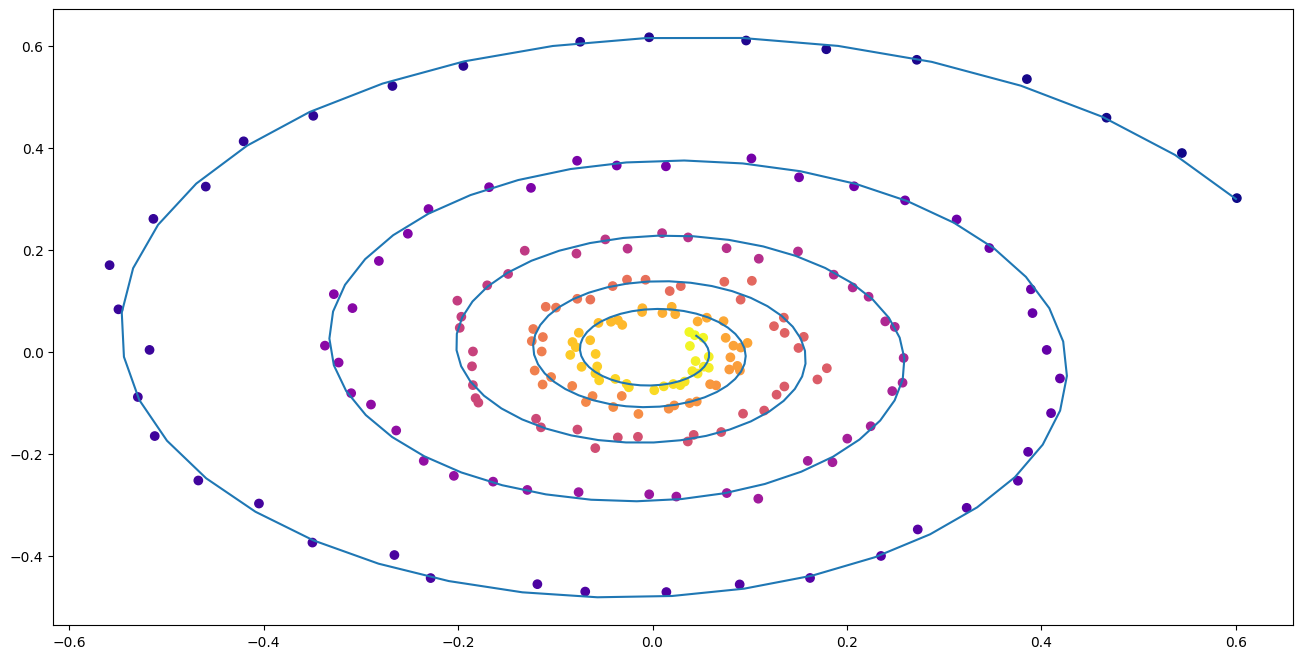

In [86]:
run_experiment(
    ode_true=ode_true,
    ode_trained=ode_trained,
    n_steps=3000,
    name="linear",
    lr=5e-3,
    plot_freq=50
)

In [88]:
ode_trained.func.lin.weight 

Parameter containing:
tensor([[-0.1101, -1.0000],
        [ 0.9991, -0.0920]], requires_grad=True)

In [89]:
ode_true.func.lin.weight 

Parameter containing:
tensor([[-0.1000, -1.0000],
        [ 1.0000, -0.1000]], requires_grad=True)

### Complicated example  

In [91]:
class TestODEF(ODEF):
    def __init__(self, A, B, x0):
        super(TestODEF, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)
        self.x0 = nn.Parameter(x0)

    def forward(self, x, t):
        xTx0 = torch.sum(x*self.x0, dim=1)
        dxdt = torch.sigmoid(xTx0) * self.A(x - self.x0) + torch.sigmoid(-xTx0) * self.B(x + self.x0)
        return dxdt
    

In [240]:
class NNODEF(ODEF):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(NNODEF, self).__init__()
        self.time_invariant = time_invariant

        if time_invariant:
            self.lin1 = nn.Linear(in_dim, hid_dim)
        else:
            self.lin1 = nn.Linear(in_dim+1, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, in_dim)
        self.elu = nn.ELU(inplace=True)

    def forward(self, x, t):
        if not self.time_invariant:
            x = torch.cat((x, t), dim=-1)

        h = self.elu(self.lin1(x))
        h = self.elu(self.lin2(h))
        out = self.lin3(h)
        return out
    

In [ ]:
func = TestODEF(
    torch.Tensor([[-0.1, -0.5], [0.5, -0.1]]), 
    torch.Tensor([[0.2, 1.], [-1, 0.2]]), 
    torch.Tensor([[-1., 0.]])
)

ode_true = NeuralODE(func)

In [110]:
func = NNODEF(2, 16, time_invariant=True)
ode_trained = NeuralODE(func)

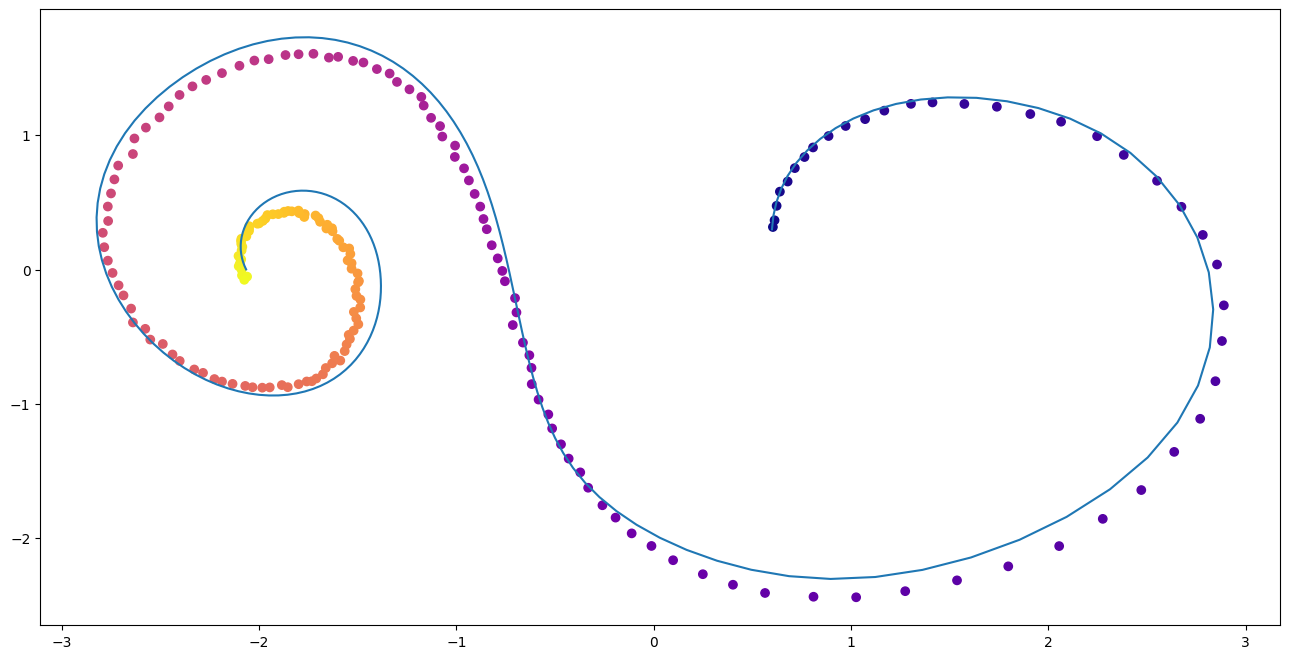

In [111]:
run_experiment(
    ode_true=ode_true,
    ode_trained=ode_trained,
    n_steps=5000,
    name="comp",
    lr=3e-3,
    plot_freq=50
)

### MNIST

In [162]:
def norm(dim):
    return nn.BatchNorm2d(dim)

def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)


def add_time(in_tensor, t):
    B, C, W, H = in_tensor.shape
    return torch.cat((in_tensor, t.expand(B, 1, W, H)), dim=1) # concatenate along the channel dimension


In [163]:
class ConvODEF(ODEF):
    
    def __init__(self, dim):
        super(ConvODEF, self).__init__()
        self.conv1 = conv3x3(dim + 1, dim)
        self.norm1 = norm(dim)
        self.conv2 = conv3x3(dim + 1, dim)
        self.norm2 = norm(dim)
    
    def forward(self, x, t):
        # Q: what does time t mean here?
        xt = add_time(x, t)
        h = self.norm1(torch.relu(self.conv1(xt)))
        ht = add_time(h, t)
        dhdt = self.norm2(torch.relu(self.conv2(ht)))
        return dhdt
    

In [164]:
# Q
# - BatchNorm2d
# - ReLU(inplace=True)
# - AdaptiveAvgPool2d

In [165]:
class NeuralODEMNISTClassifier(nn.Module):
    
    def __init__(self, ode):
        super(NeuralODEMNISTClassifier, self).__init__()
        self.donwsampling = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=0), # 28x28 --> 26x26
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1), # 26x26 --> 13x13
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1), # 13x13 --> 6x6            
        )
        self.ode = ode
        self.norm = norm(64)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.donwsampling(x)
        x = self.ode(x)
        x = self.norm(x)
        x = self.avg_pool(x)
        n_dim = torch.prod(torch.tensor(x.shape[1:])).item()
        x = x.view(-1, n_dim)
        out = self.fc(x)
        return out
        

In [166]:
#path_to_dataset = os.path.join(os.path.expanduser('~/ml_datasets/'), 'MNIST')
path_to_dataset = os.path.expanduser('~/ml_datasets/')
 

'/Users/chengweiliu/ml_datasets/'

In [167]:
img_mean, img_std = 0.1307, 0.3081

batch_size = 32

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((img_mean,), (img_std,))    
])

train_dataset = torchvision.datasets.MNIST(
    path_to_dataset,
    transform=transform,
    download=True,
    train=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_dataset = torchvision.datasets.MNIST(
    path_to_dataset,
    transform=transform,
    download=True,
    train=False    
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False
)

In [168]:
func = ConvODEF(64)
ode = NeuralODE(func)
model = NeuralODEMNISTClassifier(ode)
if use_cuda:
    model = model.cuda()

In [169]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3)

In [170]:
def train(epoch):
    train_losses = []
    
    model.train()
    loss_func = nn.CrossEntropyLoss()
    print(f"Training Epoch: {epoch} ...")
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    print('Train loss: {:.5f}'.format(np.mean(train_losses)))
    return train_losses

In [171]:
def test():
    hits = 0.
    num_items = 0
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader), total=len(test_loader)):
            if use_cuda:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            hits += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = 100. * hits / num_items
    print(f'Test accuracy: {accuracy:.3f}')
    

In [177]:
n_epochs = 5
train_losses = []
for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch)
    test()
    

Training Epoch: 1 ...


/var/folders/9m/dlg8mmt51097n77c_23_35f80000gn/T/ipykernel_38810/890591622.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.05867


  0%|          | 0/79 [00:00<?, ?it/s]

Test accuracy: 98.700
Training Epoch: 2 ...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.04565


  0%|          | 0/79 [00:00<?, ?it/s]

Test accuracy: 98.590
Training Epoch: 3 ...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.03996


  0%|          | 0/79 [00:00<?, ?it/s]

Test accuracy: 98.920
Training Epoch: 4 ...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.03491


  0%|          | 0/79 [00:00<?, ?it/s]

Test accuracy: 98.420
Training Epoch: 5 ...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.03123


  0%|          | 0/79 [00:00<?, ?it/s]

Test accuracy: 98.330


<AxesSubplot: title={'center': 'train error'}, xlabel='cum_data'>

<Figure size 900x500 with 0 Axes>

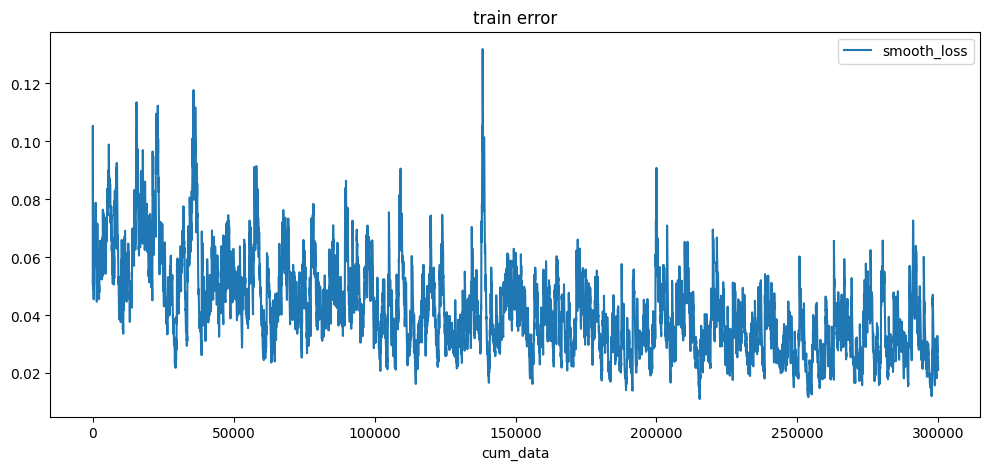

In [178]:
plt.figure(figsize=(9, 5))
history = pd.DataFrame({"loss": train_losses})
history["cum_data"] = history.index * batch_size
history["smooth_loss"] = history.loss.ewm(halflife=10).mean()
history.plot(x="cum_data", y="smooth_loss", figsize=(12, 5), title="train error")

### Generative ODE model

In [246]:
class RNNEncoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(RNNEncoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        self.rnn = nn.GRU(input_size=input_dim + 1, hidden_size=hidden_dim)
        self.hid2lat = nn.Linear(hidden_dim, 2 * latent_dim)
    
    def forward(self, x, t):
        # Q: why t.clone()?
        t = t.clone()
        t[1:] = t[:-1] - t[1:]
        t[0] = 0.
        xt = torch.cat((x, t), dim=-1)
        
        _, h0 = self.rnn(xt.flip((0,)))
        
        # latent space
        z0 = self.hid2lat(h0[0])
        z0_mean = z0[:, :self.latent_dim]
        z0_log_var = z0[:, self.latent_dim:]
        
        return z0_mean, z0_log_var
    

In [247]:
class NeuralODEDecoder(nn.Module):
    
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(NeuralODEDecoder, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        func = NNODEF(in_dim=latent_dim, hid_dim=hidden_dim, time_invariant=True)
        self.ode = NeuralODE(func)
        self.l2h = nn.Linear(latent_dim, hidden_dim)
        self.h2o = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, z0, t):
        zs = self.ode(z0, t, return_whole_sequence=True)
        hs = self.l2h(zs)
        xs = self.h2o(hs)
        return xs
    

In [248]:
class ODEVAE(nn.Module):
    
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(ODEVAE, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        self.encoder = RNNEncoder(output_dim, hidden_dim, latent_dim)
        self.decoder = NeuralODEDecoder(output_dim, hidden_dim, latent_dim)
        
    def forward(self, x, t, MAP=False):
        z_mean, z_log_var = self.encoder(x, t)
        if MAP:
            z = z_mean
        else:
            """
            \sigma = \exp(\log(\sigma)) = \exp((1/2) * \log(\sigma^2)) = \exp(0.5 * log_var)
            
            reparameterization
            z = \mu + \epsilon * \sigma
            
            hence
            z = z_mean + torch.randn_like(z_mean) * torch.exp(0.5 * z_log_var)
            """
            z = z_mean + torch.randn_like(z_mean) + torch.exp(0.5 * z_log_var)
        x_p = self.decoder(z, t)
        return x_p, z, z_mean, z_log_var
    
    def generate_with_seed(self, seed_x, t):
        seed_t_len = seed_x.shape[0]
        
        # Q: why t[:seed_t_len]?
        z_mean, z_log_var = self.encoder(seed_x, t[:seed_t_len])
        
        # Q: why not t[:seed_t_len] here?
        x_p = self.decoder(z_mean, t)
        
        return x_p
        

#### Generating dataset 

In [183]:
t_max = 6.29*5
n_points = 200
noise_std = 0.02

num_spirals = 1000

index_np = np.arange(0, n_points, 1, dtype=int)
index_np = np.hstack([index_np[:, None]])
times_np = np.linspace(0, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]] * num_spirals) # n_points, num_spirals
times = torch.from_numpy(times_np[:, :, None]).to(torch.float32)

In [184]:
normal01 = torch.distributions.Normal(0., 1.)
x0 = Variable(normal01.sample((num_spirals, 2))) * 2.0 

In [194]:
x0[:3]

tensor([[-2.0075,  1.1541],
        [ 0.3243,  0.4440],
        [ 0.4008, -0.0826]])

In [187]:
W11 = -0.1 * normal01.sample((num_spirals,)).abs() - 0.05
W22 = -0.1 * normal01.sample((num_spirals,)).abs() - 0.05
W21 = -1.0 * normal01.sample((num_spirals,)).abs()
W12 =  1.0 * normal01.sample((num_spirals,)).abs()

In [189]:
xs_list = []
for i in range(num_spirals):
    if i % 2 == 1:
        W21, W12 = W12, W21

    func = LinearODEF(torch.Tensor([[W11[i], W12[i]], [W21[i], W22[i]]]))
    ode = NeuralODE(func)

    xs = ode(x0[i:i+1], times[:, i:i+1], return_whole_sequence=True)
    xs_list.append(xs)


orig_trajs = torch.cat(xs_list, dim=1).detach()
samp_trajs = orig_trajs + torch.randn_like(orig_trajs) * noise_std
samp_ts = times

In [190]:
samp_trajs.shape, samp_ts.shape

(torch.Size([200, 1000, 2]), torch.Size([200, 1000, 1]))

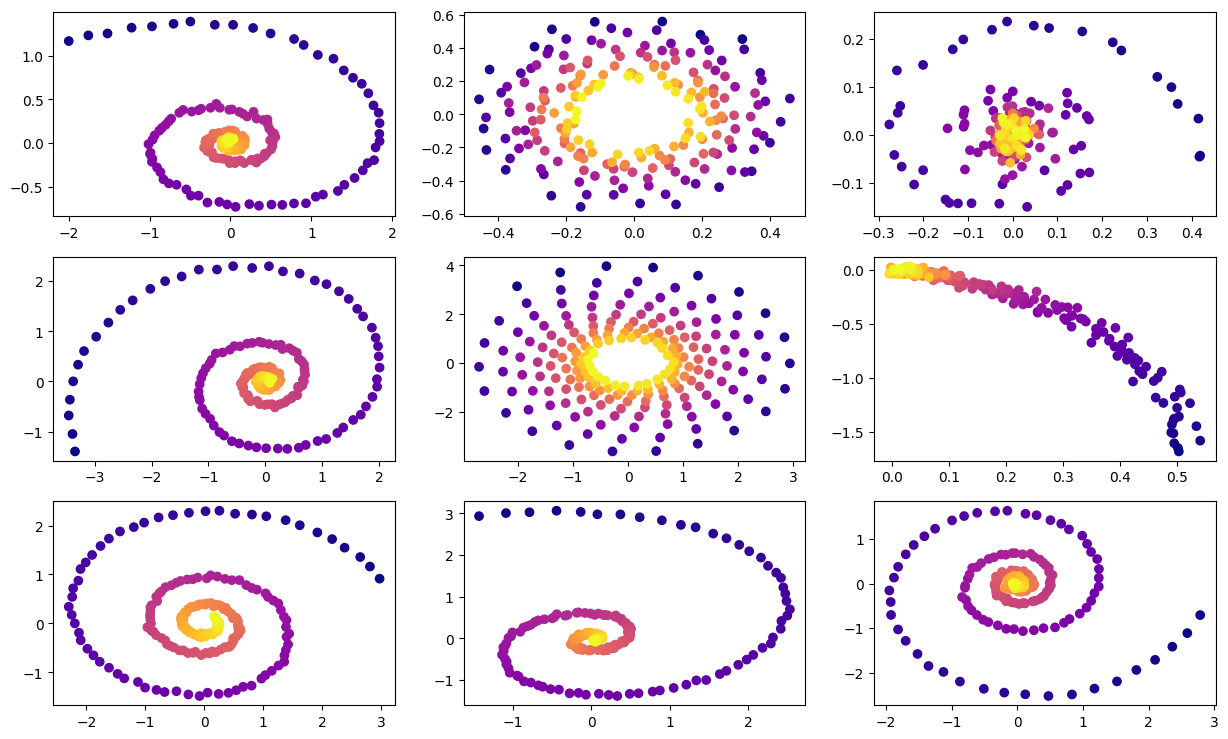

In [191]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.scatter(samp_trajs[:, i, 0], samp_trajs[:, i, 1], c=samp_ts[:, i, 0], cmap=cm.plasma)
plt.show()

In [208]:
def gen_batch(batch_size, n_sample=100):
    n_batches = samp_trajs.shape[1] // batch_size
    time_len = samp_trajs.shape[0]
    n_sample = min(n_sample, time_len)
    for i in range(n_batches):
        if n_sample > 0:
            t0_idx = np.random.multinomial(1, [1. / (time_len - n_sample)] * (time_len - n_sample))
            t0_idx = np.argmax(t0_idx)
            tM_idx = t0_idx + n_sample
        else:
            t0_idx = 0
            tM_idx = time_len

        frm, to = batch_size * i, batch_size * (i + 1)
        yield samp_trajs[t0_idx: tM_idx, frm: to], samp_ts[t0_idx: tM_idx, frm: to]

In [249]:
vae = ODEVAE(2, 64, 4)
if use_cuda:
    vae = vae.cuda()

optim = torch.optim.Adam(vae.parameters(), betas=(0.9, 0.999), lr=1e-3)

In [255]:
n_epochs = 10 #100000
batch_size = 128

Epoch: 9
575.923564365932 497.2291259765625


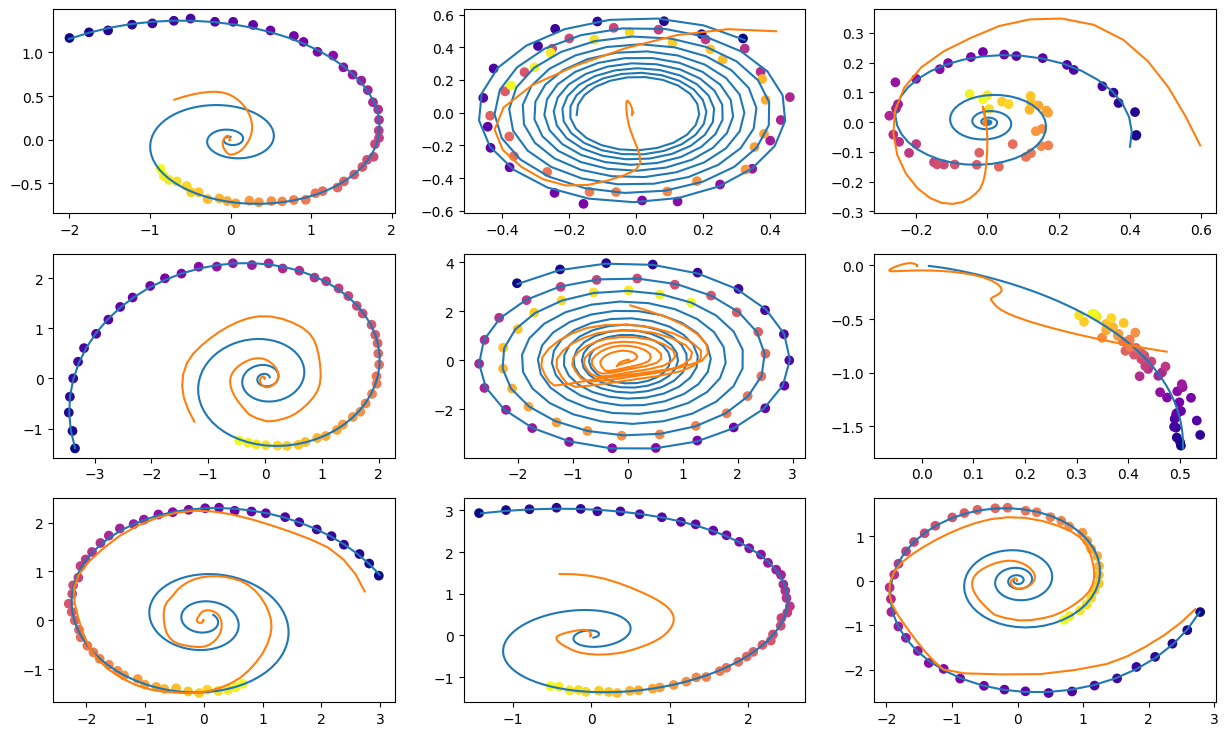

In [257]:
epoch_losses = []
for epoch_idx in range(n_epochs):
    losses = []
    train_iter = gen_batch(batch_size)
    for x, t in train_iter:
                
        if use_cuda:
            x, t = x.cuda(), t.cuda()
            
        max_len = np.random.choice([30, 50, 100])
        permutation = np.random.permutation(x.shape[0])
        permutation = np.sort(permutation[:max_len])
        
        x, t = x[permutation], t[permutation]
        
        x_p, z, z_mean, z_log_var = vae(x, t)
        
        """
        log P(x_i) >= -D_{KL} (q_{\theta}(z | x_i) || P(z)) + E_{z \sim q_{\theta}(z | x_i)} [ log P_{\phi} (x_i | z) ] = ELBO
        
        maximize ELBO = maximize log P(x_i) = maximize log-likelihood of data
        
        objective function J(x_i) = ELBO = \sum_{j=1}^D (1/2) [1 + log(\sigma_j^{(i)})^2 - (\sigma_j^{(i)})^2 - (\mu_j^{(i)})]
                                           + (1/L) \sum_l E_{z \sim q_{\theta}(z | x^{i})} [log P_{\phi} (x_i | z^{(i, l)})]
        
        loss function = - ELBO
        
        \sigma = \exp(\log(\sigma)) = \exp(1/2 \log(\sigma^2)) = \exp(1/2 log_var)
        \sigma^2 = \exp(log_var)                                        
        """
        
        KL_loss = -0.5 * torch.sum(1. + z_log_var - z_mean**2 - torch.exp(z_log_var), -1)
        error_loss = (0.5 * ((x - x_p)**2).sum(-1).sum(0) / noise_std**2) / max_len
        loss = torch.mean(error_loss + KL_loss)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.detach().cpu().item())
        
    print(f'Epoch: {epoch_idx}')
    epoch_losses.append([np.mean(losses), np.median(losses)])
    print(np.mean(losses), np.median(losses))
    
    frm, to, to_seed = 0, 200, 50
    seed_trajs = samp_trajs[frm: to_seed]
    ts = samp_ts[frm: to]
    if use_cuda:
        seed_trajs = seed_trajs.cuda()
        ts = ts.cuda()

    samp_trajs_p = to_np(vae.generate_with_seed(seed_trajs, ts))

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.scatter(
            to_np(seed_trajs[:, i, 0]), 
            to_np(seed_trajs[:, i, 1]), 
            c=to_np(ts[frm:to_seed, i, 0]), 
            cmap=cm.plasma
        )
        
        # ground truth
        ax.plot(to_np(orig_trajs[frm:to, i, 0]), to_np(orig_trajs[frm:to, i, 1]))
        
        # predictions
        ax.plot(samp_trajs_p[:, i, 0], samp_trajs_p[:, i, 1])
    plt.show()

    clear_output(wait=True)    